In [19]:
pip install twitter

In [0]:
import twitter
consumer_key = "xXxCsaUT9cWMNvlME8xx4lig7"
consumer_secret = "BkildDhWVt0S1HkcbeIUuLnvYv5dcCbrGUf1rYphJZYAnozwKF"
access_token = "1235956152493641728-LsWdsnM6a7sCWbhwFUjFlB3P0pwT3T"
access_token_secret = "N4DncudqMBa34ukK2rgNLjc2LumQwX9MRuj4zz9nwBc0B"
authorization = twitter.OAuth(access_token, access_token_secret, consumer_key, consumer_secret)
t = twitter.Twitter(auth=authorization, retry=True)

In [21]:
import os 

output_filename = '/content/python_tweets.json'
print(output_filename)

/content/python_tweets.json


In [0]:
original_users = [] 
tweets = []
user_ids = {}

In [0]:
search_results = t.search.tweets(q="python", count=100)['statuses']
for tweet in search_results:
    if 'text' in tweet:
        original_users.append(tweet['user']['screen_name']) 
        user_ids[tweet['user']['screen_name']] = tweet['user']['id']
        tweets.append(tweet['text'])

In [0]:
model_filename = '/content/python_context.pkl'


In [0]:
from sklearn.base import TransformerMixin
from nltk import word_tokenize

class NLTKBOW(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [{word: True for word in word_tokenize(document)}
                 for document in X]

In [0]:
import joblib
context_classifier = joblib.load(model_filename)

In [0]:
import nltk

In [28]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
y_pred = context_classifier.predict(tweets)

In [0]:
relevant_tweets = [tweets[i] for i in range(len(tweets)) if y_pred[i] == 1]
relevant_users = [original_users[i] for i in range(len(tweets)) if y_pred[i] == 1]

In [0]:
import time

def get_friends(t, user_id):
    friends = []
    cursor = -1
    while cursor != 0: 
        try:
            results = t.friends.ids(user_id= user_id, cursor=cursor, count=5000)
            friends.extend([friend for friend in results['ids']])
            cursor = results['next_cursor'] 
            if True or len(friends) >= 10000:
                break
        except TypeError as e:
            if results is None:
                print("You probably reached your API limit, waiting for 5 minutes")
                sys.stdout.flush() 
                time.sleep(5*60) # 5 minute wait 
            else: 
                # Some other error happened, so raise the error as normal
                raise e
        except twitter.TwitterHTTPError as e:
            print(e)
            break
        finally:
            # Break regardless -- this stops us going over our API limit
            time.sleep(60)
    return friends

In [32]:
friends = {} 
for screen_name in relevant_users:
    user_id = user_ids[screen_name]
    friends[user_id] = get_friends(t, user_id)

API rate limit reached; waiting for 87s...


In [0]:
friends = {user_id:friends[user_id] 
           for user_id in friends
           if len(friends[user_id]) > 0}

In [0]:
from collections import defaultdict
def count_friends(friends): 
    friend_count = defaultdict(int)
    for friend_list in friends.values(): 
        for friend in friend_list:
            friend_count[friend] += 1 
    return friend_count

In [0]:
friend_count = count_friends(friends)
from operator import itemgetter
best_friends = sorted(friend_count, key=friend_count.get, reverse=True)

In [36]:
best_friends

[813286,
 2736397896,
 44196397,
 4263007693,
 824070649073188865,
 218379543,
 703172305485041664,
 16663249,
 48011046,
 931055758971752448,
 216939636,
 25073877,
 19284888,
 254107028,
 555031989,
 33838201,
 34743251,
 73039079,
 63873759,
 1344951,
 20536157,
 816653,
 111366242,
 783214,
 1668100142,
 20167623,
 2467791,
 1536791610,
 11348282,
 19725644,
 771102358243860480,
 1315363538,
 212632603,
 35203319,
 99674560,
 49427323,
 3068484222,
 1636590253,
 3335731978,
 382267114,
 807095,
 13298072,
 50393960,
 66780587,
 911257773043736577,
 462527316,
 2329626888,
 1102932595,
 778393933944541185,
 2657813335,
 2754802665,
 1056126391,
 79293791,
 4398626122,
 534563976,
 2162697578,
 138203134,
 3435192275,
 14647570,
 28049003,
 275686563,
 68746721,
 15506669,
 33836629,
 80422885,
 3925032559,
 948014469044678656,
 3013684246,
 278994408,
 1075804135524585473,
 1053709905960546305,
 2344530218,
 4338452835,
 58560915,
 257842996,
 257563582,
 5988062,
 15804774,
 181561

In [0]:
import sys

In [38]:
while len(friends) < 150:
    for user_id in best_friends:
        if user_id in friends:
            continue
        print(user_id)
        sys.stdout.flush()
        friends[user_id] = get_friends(t, user_id) 
        for friend in friends[user_id]: 
            friend_count[friend] += 1
        best_friends = sorted(friend_count.items(), key=itemgetter(1), reverse=True)
        break

813286
(813286, 12)
(44196397, 12)
(44196397, 13)
(44196397, 14)
(44196397, 15)
(44196397, 16)
(44196397, 17)
(44196397, 18)
(44196397, 19)
(44196397, 20)
(44196397, 21)
(44196397, 22)
(44196397, 23)
(44196397, 24)
(44196397, 25)
(44196397, 26)
(44196397, 27)
(44196397, 28)
(44196397, 29)
(44196397, 30)
(44196397, 31)


KeyboardInterrupt: ignored

In [43]:
len(friends)

90

In [44]:
import json
friends_filename = "python_friends.json"
with open(friends_filename, 'w') as outf: 
    json.dump(friends, outf)

TypeError: ignored

In [45]:
import json
#friends_filename = os.path.join(data_folder, "python_friends.json")

NameError: ignored

In [46]:
with open(friends_filename, 'w') as outf: 
    json.dump(friends, outf)

TypeError: ignored

In [47]:
with open(friends_filename) as inf:
    friends = json.load(inf)

JSONDecodeError: ignored

In [48]:
len(friends), type(friends)

(90, dict)

In [0]:
import networkx as nx 
G = nx.DiGraph()

In [0]:
main_users = friends.keys() 
G.add_nodes_from(main_users)

In [0]:
for user_id in friends:
    for friend in friends[user_id]:
        if str(friend) in main_users: 
            G.add_edge(user_id, friend) 

In [0]:
nx.draw?

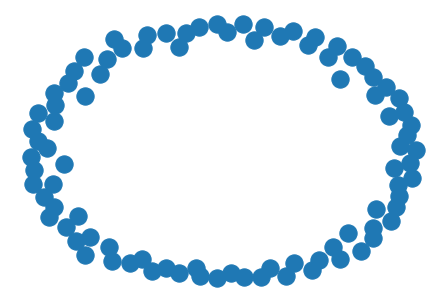

In [53]:
%matplotlib inline 
nx.draw(G)

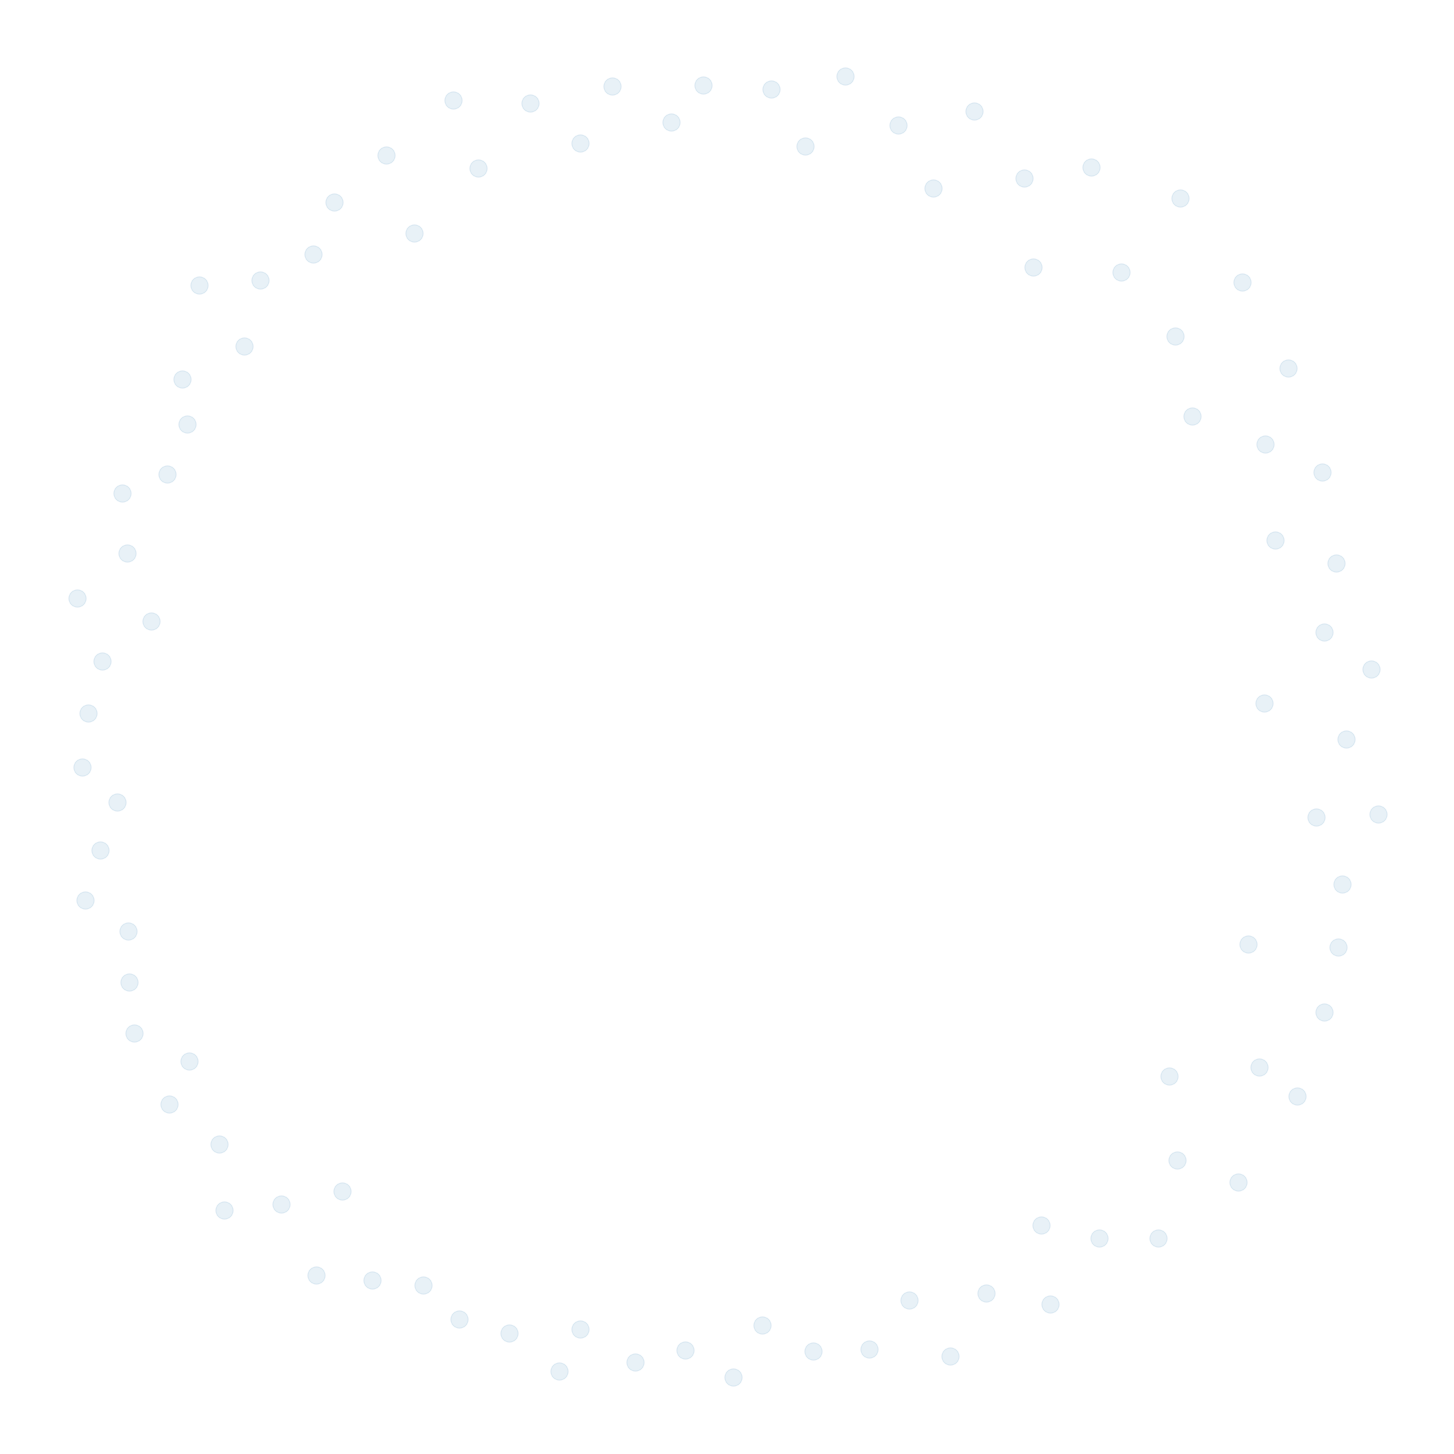

In [54]:
from matplotlib import pyplot as plt
plt.figure(3,figsize=(20,20))
nx.draw(G, alpha=0.1, edge_color='b')

In [0]:
friends = {user: set(friends[user]) for user in friends}


In [0]:
def compute_similarity(friends1, friends2):
    return len(friends1 & friends2) / (len(friends1 | friends2) + 1e-6)

In [0]:
def create_graph(followers, threshold=0): 
    G = nx.Graph()
    for user1 in friends.keys(): 
        for user2 in friends.keys(): 
            if user1 == user2:
                continue
            weight = compute_similarity(friends[user1], friends[user2])
            if weight >= threshold:
                G.add_node(user1) 
                G.add_node(user2)
                G.add_edge(user1, user2, weight=weight)
    return G

In [0]:
G = create_graph(friends)

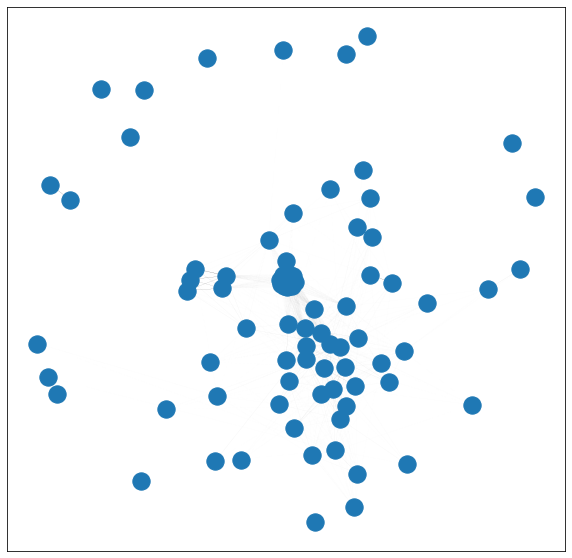

In [59]:
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
edgewidth = [ d['weight'] for (u,v,d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, width=edgewidth)

In [0]:
G = create_graph(friends, 0.1)

In [0]:
def connected_component_subgraphs(G):
   for c in nx.connected_components(G):
      yield G.subgraph(c)

In [0]:
sub_graphs = connected_component_subgraphs(G)

In [75]:
for i, sub_graph in enumerate(sub_graphs):
    n_nodes = len(sub_graph.nodes()) 
    print("Subgraph {0} has {1} nodes".format(i, n_nodes))

Subgraph 0 has 3 nodes
Subgraph 1 has 2 nodes
Subgraph 2 has 2 nodes
Subgraph 3 has 2 nodes
Subgraph 4 has 20 nodes


In [77]:
G = create_graph(friends, 0.25) 
sub_graphs = connected_component_subgraphs(G) 
for i, sub_graph in enumerate(sub_graphs): 
    n_nodes = len(sub_graph.nodes()) 
    print("Subgraph {0} has {1} nodes".format(i, n_nodes))

Subgraph 0 has 20 nodes


In [0]:
sub_graphs = connected_component_subgraphs(G) 
n_subgraphs = nx.number_connected_components(G)

In [80]:
n_subgraphs

1

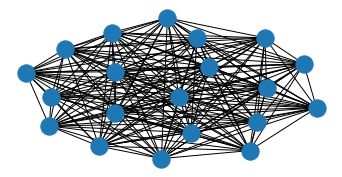

In [81]:
sub_graphs = connected_component_subgraphs(G) 
n_subgraphs = nx.number_connected_components(G)

fig = plt.figure(figsize=(20, (n_subgraphs * 3)))
for i, sub_graph in enumerate(sub_graphs):
    
    ax = fig.add_subplot(int(n_subgraphs / 3)+1, 3, i+1)
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False)
    nx.draw(sub_graph, ax=ax)

In [82]:
print("Done")

Done


In [0]:
import numpy as np
from sklearn.metrics import silhouette_score

def compute_silhouette(threshold, friends):
    G = create_graph(friends, threshold=threshold) 
    if len(G.nodes()) < 2:
        return -99
    sub_graphs = connected_component_subgraphs(G)

    if not (2 <= nx.number_connected_components(G) < len(G.nodes()) - 1): 
        return -99

    label_dict = {}
    for i, sub_graph in enumerate(sub_graphs): 
        for node in sub_graph.nodes(): 
            label_dict[node] = i

    labels = np.array([label_dict[node] for node in G.nodes()])
    X = nx.to_scipy_sparse_matrix(G).todense()
    X = 1 - X
    np.fill_diagonal(X, 0)
    return silhouette_score(X, labels, metric='precomputed')

In [0]:
def inverted_silhouette(threshold, friends):
    return -compute_silhouette(threshold, friends)

In [0]:
from scipy.optimize import minimize
result = minimize(inverted_silhouette, 0.1, args=(friends,))

In [92]:
result

      fun: -0.7274901161683427
 hess_inv: array([[1]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.1])